Epoch 1/50
101/101 [==============================] - 5s 9ms/step - loss: 0.0052 - val_loss: 7.7074e-04
Epoch 2/50
101/101 [==============================] - 1s 5ms/step - loss: 4.0773e-05 - val_loss: 7.9107e-04
Epoch 3/50
101/101 [==============================] - 1s 7ms/step - loss: 3.7879e-05 - val_loss: 7.1258e-04
Epoch 4/50
101/101 [==============================] - 1s 5ms/step - loss: 3.5589e-05 - val_loss: 6.3080e-04
Epoch 5/50
101/101 [==============================] - 0s 5ms/step - loss: 3.4166e-05 - val_loss: 6.1750e-04
Epoch 6/50
101/101 [==============================] - 0s 4ms/step - loss: 3.5952e-05 - val_loss: 5.5980e-04
Epoch 7/50
101/101 [==============================] - 1s 6ms/step - loss: 3.3153e-05 - val_loss: 5.0847e-04
Epoch 8/50
101/101 [==============================] - 0s 4ms/step - loss: 3.1319e-05 - val_loss: 4.3883e-04
Epoch 9/50
101/101 [==============================] - 0s 4ms/step - loss: 3.4643e-05 - val_loss: 4.1555e-04
Epoch 10/50
101/101 [===========

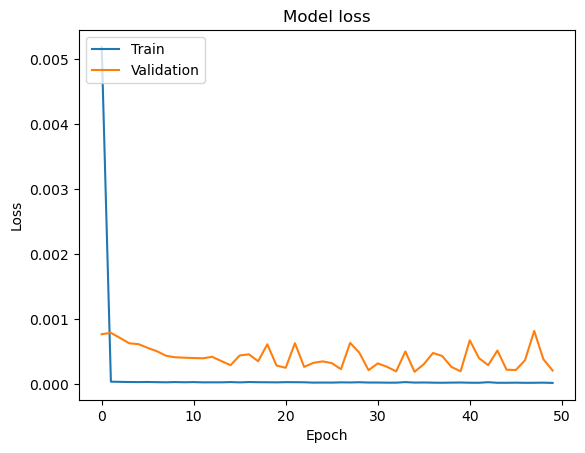

32/32 [==============================] - 0s 2ms/step
MSE: 0.09362041993486966, MAE: 0.01635677979179218, RMSE: 0.0229745413181784


In [3]:
#CNN-BiLSTM (Time Delay Embedding) 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Conv1D
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('AAPL.csv')

# Preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data.set_index('Date', inplace=True)

# Split data into features and targets
features = data.drop(columns=['Adj Close'])  # Assuming 'Adj Close' is the target
target = data[['Adj Close']]

# Split data into training and test sets before normalization
train_size = int(len(data) * 0.8)
train_features, test_features = features[:train_size], features[train_size:]
train_target, test_target = target[:train_size], target[train_size:]

# Normalize features
scaler_features = MinMaxScaler()
train_features_normalized = pd.DataFrame(scaler_features.fit_transform(train_features), columns=train_features.columns, index=train_features.index)
test_features_normalized = pd.DataFrame(scaler_features.transform(test_features), columns=test_features.columns, index=test_features.index)

# Normalize target
scaler_target = MinMaxScaler()
train_target_normalized = scaler_target.fit_transform(train_target)
test_target_normalized = scaler_target.transform(test_target)

# Reconstruct the training and testing data frames
train_data_normalized = pd.concat([train_features_normalized, pd.DataFrame(train_target_normalized, columns=['Adj Close'], index=train_features_normalized.index)], axis=1)
test_data_normalized = pd.concat([test_features_normalized, pd.DataFrame(test_target_normalized, columns=['Adj Close'], index=test_features_normalized.index)], axis=1)

# Create the sequences using time delay embedding
delay = 1
embedding_dim = 3
X, Y = [], []
for i in range(embedding_dim * delay, len(train_data_normalized)):
    X.append(train_data_normalized.iloc[i - embedding_dim * delay:i:delay].values.reshape(embedding_dim, -1))
    Y.append(train_data_normalized.iloc[i]['Adj Close'])
X, Y = np.array(X), np.array(Y)

# Further split data into training and validation sets
trainX, valX = X[:int(len(X) * 0.8)], X[int(len(X) * 0.8):]
trainY, valY = Y[:int(len(Y) * 0.8)], Y[int(len(Y) * 0.8):]

# Assuming the correct number of features is 6 after preprocessing, adjust the input_shape accordingly.
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(embedding_dim, 6))) # Adjusted from (embedding_dim, data_normalized.shape[1]-1) to (embedding_dim, 6)
model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=False)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(trainX, trainY, epochs=50, validation_data=(valX, valY), verbose=1)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Prepare test data in the sequence format
testX, testY = [], []
for i in range(embedding_dim * delay, len(test_data_normalized)):
    testX.append(test_data_normalized.iloc[i - embedding_dim * delay:i:delay].values.reshape(embedding_dim, -1))
    testY.append(test_data_normalized.iloc[i]['Adj Close'])
testX, testY = np.array(testX), np.array(testY)

# Predict on the test data
preds = model.predict(testX)

# Un-normalize the predicted values
preds_unscaled = scaler_target.inverse_transform(preds)

# Un-normalize the actual test target values
actual_unscaled = scaler_target.inverse_transform(testY.reshape(-1, 1))

# Calculate and print MSE, MAE, and RMSE
mse = mean_squared_error(testY, preds)
mae = mean_absolute_error(testY, preds)
rmse = np.sqrt(mse)
print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')

Epoch 1/50
126/126 [==============================] - 4s 7ms/step - loss: 0.0111 - val_loss: 0.6545
Epoch 2/50
126/126 [==============================] - 1s 4ms/step - loss: 1.5205e-04 - val_loss: 0.3820
Epoch 3/50
126/126 [==============================] - 1s 4ms/step - loss: 1.4891e-04 - val_loss: 0.3385
Epoch 4/50
126/126 [==============================] - 1s 4ms/step - loss: 1.3378e-04 - val_loss: 0.2346
Epoch 5/50
126/126 [==============================] - 0s 4ms/step - loss: 1.3222e-04 - val_loss: 0.1657
Epoch 6/50
126/126 [==============================] - 1s 4ms/step - loss: 1.2391e-04 - val_loss: 0.1813
Epoch 7/50
126/126 [==============================] - 1s 4ms/step - loss: 1.2570e-04 - val_loss: 0.1236
Epoch 8/50
126/126 [==============================] - 1s 4ms/step - loss: 1.2824e-04 - val_loss: 0.0609
Epoch 9/50
126/126 [==============================] - 1s 4ms/step - loss: 1.2403e-04 - val_loss: 0.0809
Epoch 10/50
126/126 [==============================] - 1s 4ms/step -

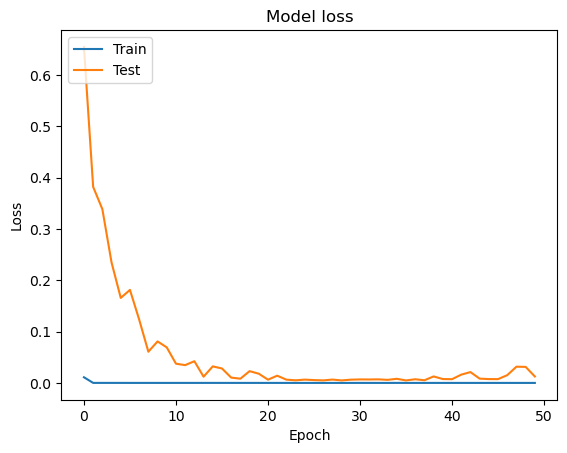

32/32 [==============================] - 1s 2ms/step
MSE: 0.012678221334941809, MAE: 0.02523192219449731, RMSE: 0.03459760803383795


In [7]:
#CNN-BiLSTM: Standard looback of 5 data points 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Conv1D, MaxPooling1D
import matplotlib.pyplot as plt
from math import sqrt

# Load data
data = pd.read_csv('AAPL.csv')

# Preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data.set_index('Date', inplace=True)

# Split data into features and target
features = data.drop(columns=['Adj Close'])  # Assuming 'Adj Close' is the target column
target = data[['Adj Close']]

# Split data into training and test sets before normalization
train_size = int(len(data) * 0.8)
train_features, test_features = features[:train_size], features[train_size:]
train_target, test_target = target[:train_size], target[train_size:]

# Normalize features
scaler_features = MinMaxScaler()
train_features_normalized = scaler_features.fit_transform(train_features)
test_features_normalized = scaler_features.transform(test_features)

# Normalize target
scaler_target = MinMaxScaler()
train_target_normalized = scaler_target.fit_transform(train_target)
test_target_normalized = scaler_target.transform(test_target)

# Reconstruct training and test sets
trainX, trainY = [], []
lookback = 5
for i in range(lookback, len(train_features_normalized)):
    trainX.append(np.hstack((train_features_normalized[i-lookback:i], train_target_normalized[i-lookback:i])))
    trainY.append(train_target_normalized[i, 0])
trainX, trainY = np.array(trainX), np.array(trainY)

testX, testY = [], []
for i in range(lookback, len(test_features_normalized)):
    testX.append(np.hstack((test_features_normalized[i-lookback:i], test_target_normalized[i-lookback:i])))
    testY.append(test_target_normalized[i, 0])
testX, testY = np.array(testX), np.array(testY)

# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(lookback, trainX.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(50, activation='relu')))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(trainX, trainY, epochs=50, validation_data=(testX, testY), verbose=1)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Predict on the test data
preds = model.predict(testX)

# Un-normalize the predicted values
preds_unscaled = scaler_target.inverse_transform(preds)

# Un-normalize the actual values
actual_unscaled = scaler_target.inverse_transform(testY.reshape(-1, 1))

# Calculate and print MSE and MAE
mse = mean_squared_error(testY, preds)
mae = mean_absolute_error(testY, preds)
rmse = np.sqrt(mse)
print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')